# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle

Load feature names.

In [2]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [4]:
def P1():
### STUDENT START ###

    for i in range(1,51):
        pca = PCA(n_components=i)
        pca.fit(train_data)
        print "Fraction of the total variance in the training data explained by the {0} principal component(s): {1:.3g}".format(i, np.sum(pca.explained_variance_ratio_))

### STUDENT END ###

P1()

Fraction of the total variance in the training data explained by the 1 principal component(s): 0.164
Fraction of the total variance in the training data explained by the 2 principal component(s): 0.297
Fraction of the total variance in the training data explained by the 3 principal component(s): 0.399
Fraction of the total variance in the training data explained by the 4 principal component(s): 0.47
Fraction of the total variance in the training data explained by the 5 principal component(s): 0.508
Fraction of the total variance in the training data explained by the 6 principal component(s): 0.545
Fraction of the total variance in the training data explained by the 7 principal component(s): 0.576
Fraction of the total variance in the training data explained by the 8 principal component(s): 0.604
Fraction of the total variance in the training data explained by the 9 principal component(s): 0.63
Fraction of the total variance in the training data explained by the 10 principal component(s

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

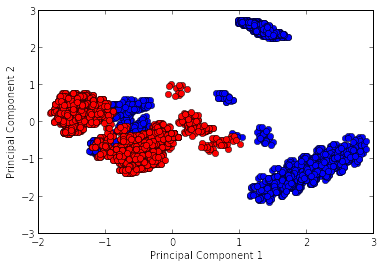

In [5]:
def P2():
### STUDENT START ###

    pca = PCA(n_components=2)
    pca.fit(train_data)
    df = pd.DataFrame(pca.transform(train_data), columns = ['pc_1', 'pc_2'])
    
    indice_poisonous = train_labels == 1
    indice_non_poisonous = train_labels == 0

    plt.plot(df['pc_1'][indice_poisonous], df['pc_2'][indice_poisonous], 'bo')
    plt.plot(df['pc_1'][indice_non_poisonous], df['pc_2'][indice_non_poisonous], 'ro')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

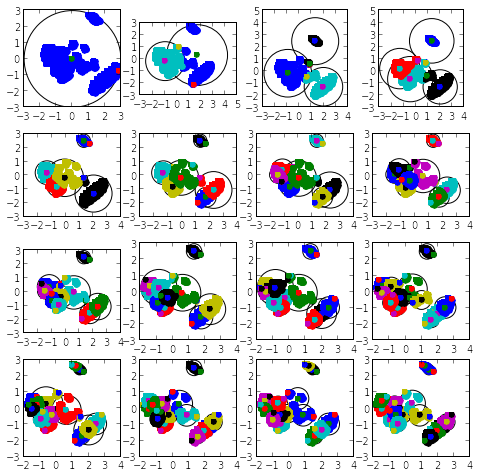

In [6]:
def P3():
### STUDENT START ###       

    pca = PCA(n_components=2)
    pca.fit(train_data)
    df = pd.DataFrame(pca.transform(train_data), columns = ['pc_1', 'pc_2'])
    
    # Initiailize figure
    fig1 = plt.figure(figsize=(8,8))
    
    # Count varible for keeping track of figures 
    count_figures = 1
        
    for i in range(1, 17):
        kmeans = KMeans(n_clusters=i)
        dists = pd.DataFrame(kmeans.fit_transform(df))
        
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_

        ax1 = fig1.add_subplot(4, 4, count_figures, aspect='equal')
        
        for label in set(labels):
            centroid = centroids[label]
            indice_current_label = labels == label
            points = np.array(df[indice_current_label])
            current_dists = list(dists[indice_current_label][label])
            
            # Get the most distant point from the centroid
            farthest_point = points[current_dists.index(max(current_dists))]

            ax1.plot(
                points.T[0], points.T[1], label='{} cluster'.format(i), linestyle='none', marker='o', mec='none',
            )            
            circle = plt.Circle(
                (centroid[0], centroid[1]), max(current_dists), linestyle='solid', linewidth=1, fill=False)
            ax1.add_patch(circle)
            ax1.plot(
                centroid[0], centroid[1], label='{} cluster'.format(i), linestyle='none', marker='o', mec='none',
            )
            ax1.plot(
                farthest_point[0], farthest_point[1], label='{} cluster'.format(i), linestyle='none', marker='o',
                mec='none',
            )
        
        # Increment the counter for figures
        count_figures = count_figures + 1
    
### STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

In [39]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

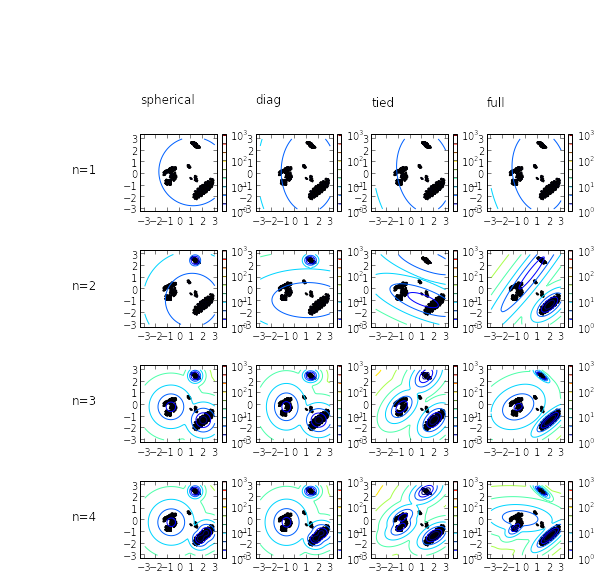

In [48]:
def P4():
### STUDENT START ###

    pca = PCA(n_components=2)
    pca.fit(train_data)
    train_data_transformed = pca.transform(train_data)
    X_train = train_data_transformed[train_labels == 1]

    # Initiailize figure
    fig1 = plt.figure(figsize=(10, 10))
    
    # Count varible for keeping track of figures
    count_figures = 1

    for i in range(0, 5):
        ax1 = fig1.add_subplot(5, 5, count_figures, aspect='0.3')
        ax1.axis('off')
        
        # If not 0, print out the current row number i
        if i != 0:
            ax1.text(0.5, 0.5, 'n='+str(i), fontsize=12)

        # Increment the counter for figures
        count_figures = count_figures + 1
        
        for covariance in ('spherical', 'diag', 'tied', 'full'):
            
            # Print out the header if i == 0
            if i == 0:
                ax1 = fig1.add_subplot(5, 5, count_figures, aspect='equal')
                ax1.text(0, 0, covariance, fontsize=12, horizontalalignment='left',
                         verticalalignment='bottom')
                ax1.axis('off')
                count_figures = count_figures + 1
                continue
            
            # If not header, make the aspect ratio equal
            ax1 = fig1.add_subplot(5, 5, count_figures, aspect='equal')
                
            # fit a Gaussian Mixture Model with two components
            clf = mixture.GaussianMixture(n_components=i, covariance_type=covariance)
            clf.fit(X_train)

            # display predicted scores by the model as a contour plot
            x = np.linspace(-3., 3.)
            y = np.linspace(-3., 3.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -clf.score_samples(XX)
            Z = Z.reshape(X.shape)

            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                             levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            plt.scatter(X_train[:, 0], X_train[:, 1], .8)
            
            # Increment the counter for figures
            count_figures = count_figures + 1
    
### STUDENT END ###

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [8]:
#def P5():
### STUDENT START ###

### STUDENT END ###

#P5()

(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [9]:
#def P6():
### STUDENT START ###

### STUDENT END ###

#P6()